In [ ]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
df_train=pd.read_hdf('dftrain.h5')

In [ ]:
df_test=pd.read_hdf('dfvalid.h5')

In [ ]:
df_test_y=pd.read_csv('dfvalid_groundtruth.csv')

In [ ]:
df_test_y=pd.merge(df_test_y,df_test,left_index=True,right_index=True)
df_test_y
fcols=df_test_y.columns[2:61141]

In [ ]:
s1=df_test_y[df_test_y['seqID']==1][fcols].T

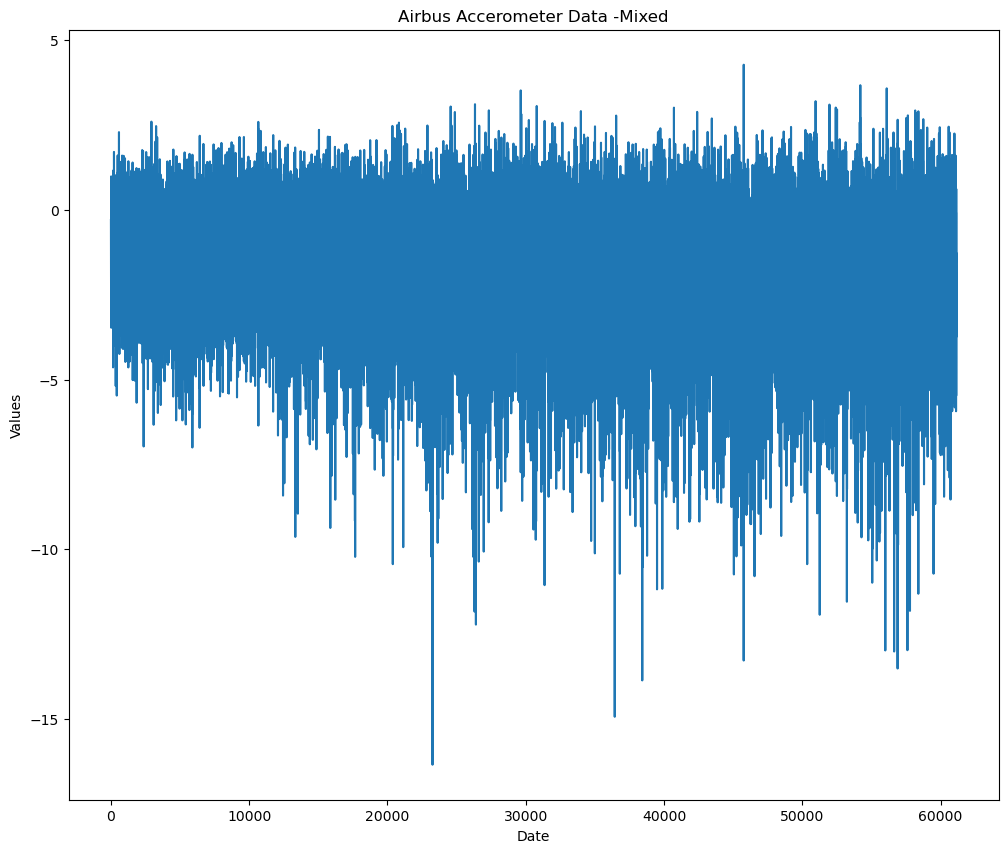

In [ ]:
import matplotlib.pyplot as plt
 # Using a inbuilt style to change
# the look and feel of the plot
#plt.style.use("fivethirtyeight")

# setting figure size to 12, 10
plt.figure(figsize=(12, 10))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Airbus Accerometer Data -Mixed")
plt.plot(np.array(s1))
#plt.plot(dataframe.rolling( window=2, min_periods=1).mean()["A"])

In [ ]:
def down_sample_preprocess(df):
    dfret = pd.DataFrame()  # Initialize an empty DataFrame to store the processed data
    for i in range(0, len(df)):
        #print("Row: ", i)
        input = df[i:i + 1]  # Select a single row from the input DataFrame
        #print("Shape of input ",input.shape)
        data = input.copy()  # Create a copy of the selected row
        data = data.T  # Transpose the data (to have time series data in columns)
        data.index = pd.date_range(start='1/1/2018', periods=input.shape[1], freq='L')
        # Set the index of the transposed data as a date range starting from '1/1/2018',
        # with the number of periods equal to the length of the selected row, and with a frequency of 'L' (milliseconds)

        #print(data.head)
        df_t1 = data.resample('2048L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'

        data_resample_mean = data.resample('2048L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        level_shift = (data_resample_mean - data_resample_mean.shift(-1)).interpolate()  # Perform a level shift operation on the resampled data
        df_t2 = level_shift.resample('2048L').max()  # Resample the level shifted data to a 1024L frequency and calculate the maximum
        df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'

        df_t3 = data.resample('2048L').apply(lambda x: kurtosis(x))  # Resample the data to a 1024L frequency and apply the kurtosis function
        df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'

        df_train_c = df_t1.join(df_t2).join(df_t3)  # Join the resampled dataframes into a single dataframe
        df_train_c['s'] = range(0, len(df_train_c))  # Add a new column 's' with values ranging from 0 to the length of the dataframe
        df_train_c['id'] = i  # Add a new column 'id' with the value of the current row index

        df2 = df_train_c.pivot_table(index=['id'], columns=['s'], values=['v_avg', 'v_shift', 'v_kurt'])  # Pivot the dataframe to reshape it
        df2 = df2.sort_index(axis=1, level=1)  # Sort the columns in ascending order

        df2.columns = [f'{x}_{y}' for x, y in df2.columns]  # Rename the columns with a combination of the original column names and the index level values
        df2 = df2.reset_index()  # Reset the index of the dataframe

        if (len(dfret) == 0):
            dfret = df2  # If the resulting dataframe is empty, assign it to dfret
        else:
            dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret

    return dfret  # Return the processed dataframe

In [ ]:
df_train_ds=down_sample_preprocess(df_train)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

In [ ]:
feature_cols=df_train_ds.columns[1:]

In [ ]:
feature_cols

Index(['v_avg_0', 'v_kurt_0', 'v_shift_0', 'v_avg_1', 'v_kurt_1', 'v_shift_1',
       'v_avg_2', 'v_kurt_2', 'v_shift_2', 'v_avg_3', 'v_kurt_3', 'v_shift_3',
       'v_avg_4', 'v_kurt_4', 'v_shift_4', 'v_avg_5', 'v_kurt_5', 'v_shift_5',
       'v_avg_6', 'v_kurt_6', 'v_shift_6', 'v_avg_7', 'v_kurt_7', 'v_shift_7',
       'v_avg_8', 'v_kurt_8', 'v_shift_8', 'v_avg_9', 'v_kurt_9', 'v_shift_9',
       'v_avg_10', 'v_kurt_10', 'v_shift_10', 'v_avg_11', 'v_kurt_11',
       'v_shift_11', 'v_avg_12', 'v_kurt_12', 'v_shift_12', 'v_avg_13',
       'v_kurt_13', 'v_shift_13', 'v_avg_14', 'v_kurt_14', 'v_shift_14',
       'v_avg_15', 'v_kurt_15', 'v_shift_15', 'v_avg_16', 'v_kurt_16',
       'v_shift_16', 'v_avg_17', 'v_kurt_17', 'v_shift_17', 'v_avg_18',
       'v_kurt_18', 'v_shift_18', 'v_avg_19', 'v_kurt_19', 'v_shift_19',
       'v_avg_20', 'v_kurt_20', 'v_shift_20', 'v_avg_21', 'v_kurt_21',
       'v_shift_21', 'v_avg_22', 'v_kurt_22', 'v_shift_22', 'v_avg_23',
       'v_kurt_23', 'v_shift_2

In [ ]:
df_train.shape

(1677, 61440)

In [ ]:
df_train_ds.shape

(1677, 91)

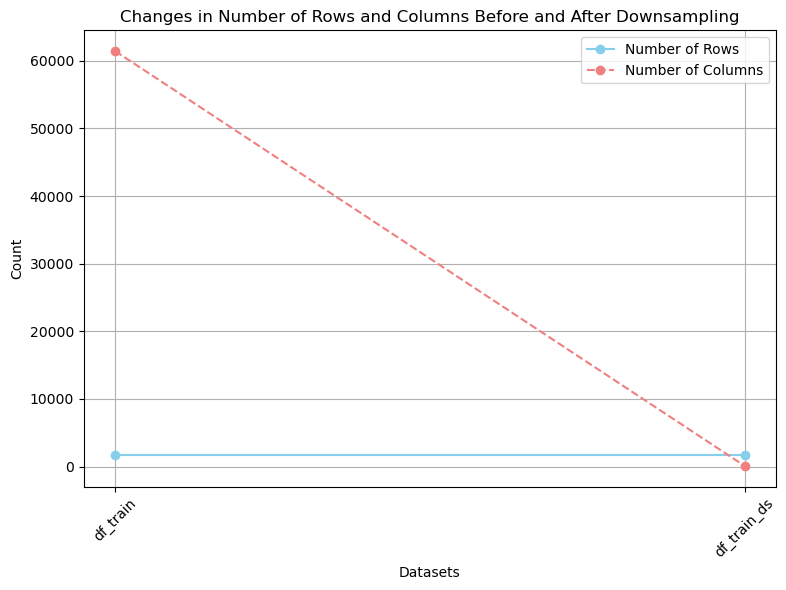

In [ ]:
import matplotlib.pyplot as plt

# Extract the number of rows and columns for df_train and df_train_ds
rows_train, cols_train = df_train.shape
rows_train_ds, cols_train_ds = df_train_ds.shape

# Create lists to hold the data
datasets = ['df_train', 'df_train_ds']
rows = [rows_train, rows_train_ds]
cols = [cols_train, cols_train_ds]

# Create line plots
plt.figure(figsize=(8, 6))
plt.plot(datasets, rows, marker='o', label='Number of Rows', color='skyblue', linestyle='-')
plt.plot(datasets, cols, marker='o', label='Number of Columns', color='lightcoral', linestyle='--')

plt.xlabel('Datasets')
plt.ylabel('Count')
plt.title('Changes in Number of Rows and Columns Before and After Downsampling')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
import copy

X_train = copy.copy(df_train_ds[feature_cols])

In [ ]:
df_test_ds=down_sample_preprocess (df_test)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

In [ ]:
import copy
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

X_test = copy.copy(df_test_ds.drop('id', axis=1))
X_test

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_26,v_avg_27,v_kurt_27,v_shift_27,v_avg_28,v_kurt_28,v_shift_28,v_avg_29,v_kurt_29,v_shift_29
0,0.028891,-0.248347,0.036433,-0.007542,-0.031962,0.003784,-0.011325,0.147725,0.010099,-0.021424,...,0.001748,0.023304,-0.271101,0.002224,0.021080,0.002660,-0.002567,0.023647,-0.117479,-0.002567
0,-1.533344,-0.430126,-0.088610,-1.444734,-0.156967,0.160548,-1.605281,-0.139650,-0.036789,-1.568493,...,-0.060452,-2.298544,2.914535,-0.233174,-2.065369,2.246092,-0.180466,-1.884903,1.428274,-0.180466
0,-0.007497,-0.607686,0.001460,-0.008956,-0.727462,-0.000484,-0.008472,-0.273826,0.000204,-0.008676,...,-0.000518,-0.007961,-1.095714,0.001600,-0.009561,-1.113118,-0.003052,-0.006509,-0.960778,-0.003052
0,0.010959,0.977106,0.010581,0.000378,-0.221109,0.001078,-0.000700,-0.202088,-0.001475,0.000775,...,-0.001459,0.002015,-0.230270,0.001477,0.000538,-0.290222,0.000886,-0.000348,0.017526,0.000886
0,-8.391439,0.019198,0.614136,-9.005575,-0.076338,0.469204,-9.474779,0.018945,-0.726552,-8.748226,...,-0.411862,-6.110236,0.051164,-0.164790,-5.945445,0.276055,0.150920,-6.096366,0.310504,0.150920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-18.255630,-0.589996,0.103494,-18.359124,-1.407668,0.147645,-18.506768,-0.966629,0.074142,-18.580910,...,0.039223,-19.418877,-0.757628,0.047763,-19.466640,-0.433184,0.026777,-19.493417,-0.605999,0.026777
0,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,...,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000
0,0.028682,-0.224219,0.003732,0.024950,-0.346075,0.001843,0.023108,0.065907,0.000066,0.023042,...,0.076230,0.191711,0.113576,0.025760,0.165951,0.034465,0.003536,0.162415,0.114578,0.003536
0,0.006286,-0.095399,0.002641,0.003644,-0.275869,-0.007697,0.011341,0.019503,-0.004483,0.015824,...,0.014106,-0.004808,-1.100707,-0.008148,0.003340,-1.037594,-0.041390,0.044730,-0.926771,-0.041390


In [ ]:
X_train

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_26,v_avg_27,v_kurt_27,v_shift_27,v_avg_28,v_kurt_28,v_shift_28,v_avg_29,v_kurt_29,v_shift_29
0,0.039142,0.082738,0.000158,0.038984,-0.114852,-0.000577,0.039561,-0.026314,0.000548,0.039013,...,0.001189,0.038129,0.001613,-0.001044,0.039173,-0.277659,0.000046,0.039127,-0.014763,0.000046
0,0.005682,-1.252512,0.001392,0.004289,-1.013483,0.000707,0.003582,-1.452378,0.003015,0.000567,...,0.002824,0.001684,-1.443475,0.000618,0.001066,-1.415570,-0.002007,0.003073,-1.444962,-0.002007
0,0.005145,-0.754715,-0.011475,0.016619,-0.669953,0.007129,0.009490,-1.363982,-0.004378,0.013868,...,-0.003335,0.013769,-1.436060,-0.001302,0.015072,-1.430412,0.002242,0.012830,-1.443224,0.002242
0,0.005108,-0.986732,-0.000817,0.005925,-0.889680,0.001148,0.004777,0.304130,0.000336,0.004441,...,-0.001021,0.005061,-0.480948,-0.000723,0.005784,-0.181943,0.002098,0.003686,-0.365323,0.002098
0,0.029492,-1.408990,0.004205,0.025287,-1.463355,-0.009980,0.035267,-1.438308,0.004531,0.030736,...,0.024835,0.005704,-1.321140,-0.049865,0.055570,-0.984286,0.005606,0.049964,-1.253756,0.005606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.002212,-1.020951,0.003948,-0.006161,-1.258814,0.000821,-0.006981,-1.286996,-0.006505,-0.000476,...,-0.003935,-0.005724,-0.622157,0.003533,-0.009257,0.334730,-0.004183,-0.005074,0.192123,-0.004183
0,-0.098622,-1.143808,-0.030051,-0.068571,-1.009945,-0.044045,-0.024526,-0.852119,-0.008806,-0.015720,...,-0.001914,-0.041650,0.100091,-0.021628,-0.020022,8.046026,-0.016322,-0.003700,9.704546,-0.016322
0,-0.011027,-1.315232,0.020654,-0.031681,-1.283140,0.001916,-0.033597,-1.133041,0.007060,-0.040657,...,-0.000048,-0.027492,-0.894588,-0.003544,-0.023947,1.629726,-0.003294,-0.020654,6.308706,-0.003294
0,-0.026082,0.145217,-0.001345,-0.024737,0.110328,-0.005235,-0.019503,0.132654,0.000218,-0.019721,...,0.001888,-0.024500,-0.426736,0.000010,-0.024510,-0.057443,-0.001706,-0.022804,1.103013,-0.001706


In [ ]:
y = df_test_y['anomaly'].values

# VAE

In [ ]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 90)]         0           []                               
                                                                                                  
 dense_114 (Dense)              (None, 45)           4095        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 30)           1380        ['dense_114[0][0]']              
                                                                                                  
 z_log_var (Dense)              (None, 30)           1380        ['dense_114[0][0]']              
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_115 (Dense)           (None, 45)                1395      
                                                                 
 dense_116 (Dense)           (None, 90)                4140      
                                                                 
Total params: 5,535
Trainable params: 5,535
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=300,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 90)]              0         
                                                                 
 encoder (Functional)        (None, 30)                6855      
                                                                 
 decoder (Functional)        (None, 90)                5535      
                                                                 
Total params: 12,390
Trainable params: 12,390
Non-trainable params: 0
_________________________________________________________________
Train on 1677 samples
Epoch 1/300
1677/1677 [==============================] - 7s 4ms/sample - loss: 37551067.3549
Epoch 2/300
1677/1677 [==============================] - 0s 85us/sample - loss: 7248009.4006
Epoch 3/300
1677/1677 [==============================] - 0s 92us/sample - loss: 2704669.3692
Epoch 4/300
1677/1

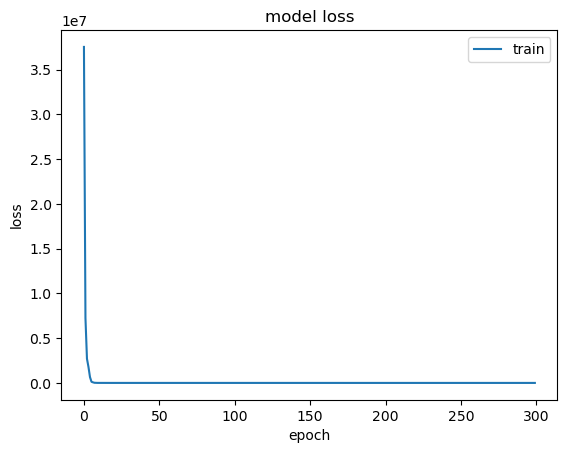

In [ ]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
X_train_pred = vae_model.predict(X_train)

C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.16540381406384738
median error 0.13525765687294097
99Q: 0.4775324720946297
setting threshold on 0.4775324720946297 


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Assuming the 'predictions' variable contains the data with shape (594, 2880)
predictions=vae_model.predict(X_test)
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (594,)
Y_pred = vector_reduced.reshape(594,)

print(Y_pred.shape)
Y_pred


(594,)


array([-1.00196347e-01, -2.43581831e-01, -1.00438125e-01, -9.91282091e-02,
       -1.00452363e-01, -1.81939393e-01, -9.82249081e-02, -9.35121626e-02,
       -3.08861315e-01, -9.85929444e-02, -1.00448936e-01, -9.98259559e-02,
       -9.99353081e-02, -1.00445621e-01, -1.00452363e-01, -6.10638335e-02,
       -1.00452363e-01, -2.94881433e-01, -1.00116581e-01, -9.49142352e-02,
       -1.00384429e-01, -1.00452363e-01, -8.14856514e-02, -1.00420624e-01,
        5.33132648e+00, -1.35919884e-01, -9.82255042e-02, -2.20489442e-01,
       -1.00452363e-01, -9.11359042e-02, -6.66609406e-02, -8.55252147e-02,
       -2.13222414e-01, -5.80591559e-02, -1.00085497e-01, -1.00387909e-01,
       -1.00452363e-01, -3.74995545e-02, -9.00423899e-02, -9.68931541e-02,
       -9.96219739e-02, -9.97041985e-02, -1.00452363e-01, -1.00452363e-01,
       -2.86381274e-01, -9.13245827e-02, -9.97791588e-02, -1.00275733e-01,
       -9.96154547e-02, -9.98120829e-02, -9.97143090e-02, -1.00810826e-01,
       -9.90349799e-02, -

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)


[0.47497186 0.43940386 0.47491157 0.4752382  0.47490802 0.45464018
 0.47546348 0.476639   0.42339268 0.47537172 0.4749089  0.47506422
 0.47503695 0.4749097  0.47490802 0.48473877 0.47490802 0.42680925
 0.47499174 0.47628924 0.47492495 0.47490802 0.4796399  0.47491592
 0.9951857  0.46607226 0.4754634  0.44509983 0.47490802 0.47723174
 0.48334092 0.47863168 0.44689542 0.48548928 0.4749995  0.47492403
 0.47490802 0.4906262  0.4775046  0.47579563 0.47511506 0.47509456
 0.47490802 0.47490802 0.42889    0.47718474 0.4750759  0.47495207
 0.47511673 0.47506768 0.47509208 0.47481862 0.47526145 0.47490802
 0.47490802 0.47490802 0.4750202  0.47496998 0.43723318 0.4412366
 0.4755062  0.47490683 0.5674245  0.47490802 0.47496313 0.4756329
 0.47490802 0.47521132 0.47495222 0.43176374 0.47985992 0.4751443
 0.48661196 0.47490802 0.47819376 0.47491318 0.47502112 0.47146702
 0.47490802 0.47490802 0.46180752 0.47490802 0.47490802 0.45906365
 0.4750775  0.47490802 0.4834567  0.47491705 0.4749093  0.4790147

In [ ]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - y) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2514782987269265


In [ ]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(y * np.log(Y_pred_sigmoid + epsilon) + (1 - y) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 0.6924005392813422


array([0.6443035 , 0.82233632, 0.64418858, 0.64481086, 0.74463415,
       0.78824902, 0.64524031, 0.64748389, 0.85945523, 0.64506531,
       0.64418346, 0.64447933, 0.74436271, 0.74463063, 0.74463415,
       0.66308129, 0.74463415, 0.85141808, 0.64434129, 0.64681578,
       0.64421403, 0.74463415, 0.65323418, 0.64419687, 0.00482595,
       0.76341456, 0.64524007, 0.80945671, 0.74463415, 0.64861703,
       0.66037202, 0.65129852, 0.80543065, 0.6645388 , 0.64435601,
       0.64421231, 0.74463415, 0.67457318, 0.64913911, 0.64587367,
       0.64457619, 0.64453715, 0.74463415, 0.74463415, 0.84655482,
       0.64852715, 0.64450163, 0.64426577, 0.64457941, 0.74429804,
       0.64453238, 0.74482238, 0.64485514, 0.74463415, 0.74463415,
       0.74463415, 0.64439541, 0.74450368, 0.82728863, 0.81817406,
       0.64532167, 0.74463665, 0.83799833, 0.74463415, 0.64428681,
       0.6455633 , 0.74463415, 0.74399567, 0.64426601, 0.83987677,
       0.6536572 , 0.64463186, 0.66672331, 0.74463415, 0.73773

In [ ]:
error_thresh=0.7
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.48653198653198654

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, anomalies))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       297
         1.0       0.98      0.95      0.97       297

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594

